In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Загрузка данных из Excel-файла и первичный анализ
target_xlsx ='https://lms.skillfactory.ru/asset-v1:SkillFactory+MIFIML-2sem+2025+type@asset+block@%D0%94%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B4%D0%BB%D1%8F_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B8__%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%9C%D0%9E.xlsx'
df = pd.read_excel(target_xlsx)

In [ ]:
display(df.head())

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
!pip install catboost xgboost scikit-learn matplotlib seaborn joblib pandas numpy

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
target = 'SI'
cols_to_drop= ['IC50, mM', 'CC50, mM', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)
original_count = len(df)
print(f"Исходное количество записей: {original_count}")

Исходное количество записей: 1001


In [ ]:
mean_SI = df[target].mean()
std_SI = df[target].std()
lower_bound = mean_SI - 2 * std_SI
upper_bound = mean_SI + 2 * std_SI

df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)].copy()

filtered_count = len(df)
print(f"Количество записей после удаления выбросов: {filtered_count}")
print(f"Удалено записей: {original_count - filtered_count}")


Количество записей после удаления выбросов: 993
Удалено записей: 8


In [ ]:
# Создание целевой переменной
df['SI_8'] = (df[target] > 8).astype(int)
target = 'SI_8'

In [ ]:
RANDOM_STATE = 123

In [ ]:
# Исключаем ненужные столбцы
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI', target]
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

In [ ]:
df_regress = X.copy()

# Добавление новых признаков молярный
df_regress['MolLogP_MolWt'] = df_regress['MolLogP'] * df_regress['MolWt']

In [ ]:
# Полиномиальные признаки
existing_poly_cols = [col for col in ['MolLogP', 'MolWt'] if col in df_regress.columns]

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_regress[existing_poly_cols])
poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_regress.index)
for col in new_poly_df.columns:
   if col not in df_regress.columns:
       df_regress[col] = new_poly_df[col]

In [ ]:
df_regress['MolLogP_gt_3'] = (df_regress['MolLogP'] > 3).astype(int)

In [ ]:
imputer = SimpleImputer(strategy='median')
df_regress = pd.DataFrame(imputer.fit_transform(df_regress), columns=df_regress.columns)

In [ ]:
print("Получили новые признаки:", [col for col in df_regress.columns if col not in df.columns])

Получили новые признаки: ['MolLogP_MolWt', 'MolLogP^2', 'MolLogP MolWt', 'MolWt^2', 'MolLogP_gt_3']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_regress, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


In [ ]:
results = []

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score,
                           f1_score, precision_score,
                           recall_score, confusion_matrix)

In [ ]:
#Обучение и прогноз модели Logistic Regression

name = 'Logistic Regression'
model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

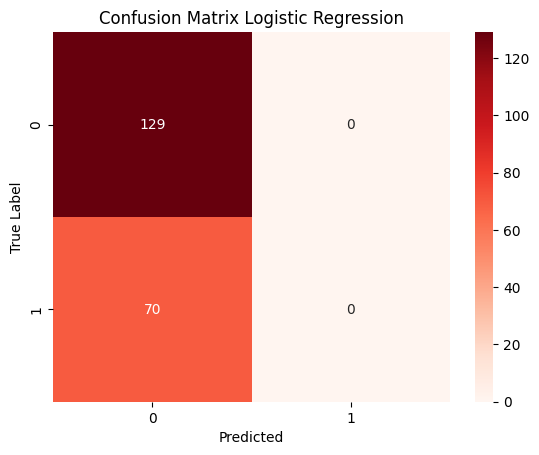

In [ ]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [ ]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Model': 'Logistic Regression',
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0,
 'Accuracy': 0.6482412060301508,
 'ROC-AUC': np.float64(0.5403100775193798)}

**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Обучение и прогноз модели KNN

name = 'KNN'
model =  KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

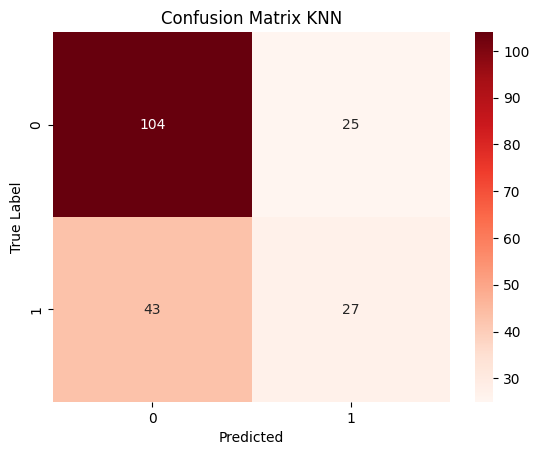

In [ ]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [ ]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'KNN',
 'Precision': 0.5192307692307693,
 'Recall': 0.38571428571428573,
 'F1 Score': 0.4426229508196721,
 'Accuracy': 0.6582914572864321,
 'ROC-AUC': np.float64(0.539313399778516)}

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Обучение и прогноз модели Random Forest

name = 'Random Forest'
model =  RandomForestClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0])

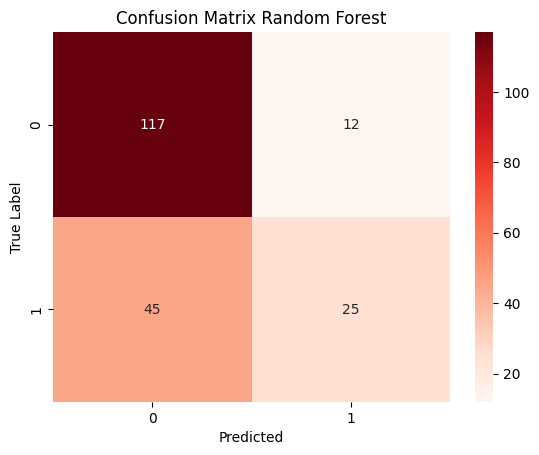

In [ ]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [ ]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Random Forest',
 'Precision': 0.6756756756756757,
 'Recall': 0.35714285714285715,
 'F1 Score': 0.4672897196261682,
 'Accuracy': 0.7135678391959799,
 'ROC-AUC': np.float64(0.7163344407530455)}

**Gradient Boosting**

In [ ]:
from sklearn.ensemble import  GradientBoostingClassifier

In [ ]:
#Обучение и прогноз модели Gradient Boosting

name = 'Gradient Boosting'
model =  GradientBoostingClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

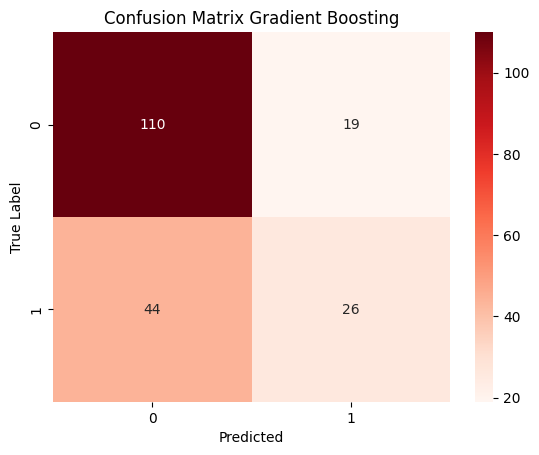

In [ ]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [ ]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Gradient Boosting',
 'Precision': 0.5777777777777777,
 'Recall': 0.37142857142857144,
 'F1 Score': 0.45217391304347826,
 'Accuracy': 0.6834170854271356,
 'ROC-AUC': np.float64(0.7114064230343301)}

**HistGradientBoosting**

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
#Обучение и прогноз модели HistGradientBoosting

name = 'HistGradientBoosting'
model =  HistGradientBoostingClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0])

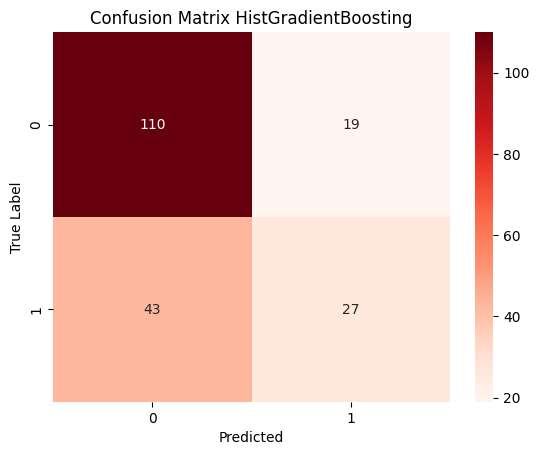

In [ ]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [ ]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'HistGradientBoosting',
 'Precision': 0.5869565217391305,
 'Recall': 0.38571428571428573,
 'F1 Score': 0.46551724137931033,
 'Accuracy': 0.6884422110552764,
 'ROC-AUC': np.float64(0.7133997785160576)}

**XGBoost**

In [ ]:
from xgboost import XGBClassifier

In [ ]:
#Обучение и прогноз модели XGBoost

name = 'XGBoost'
model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0])

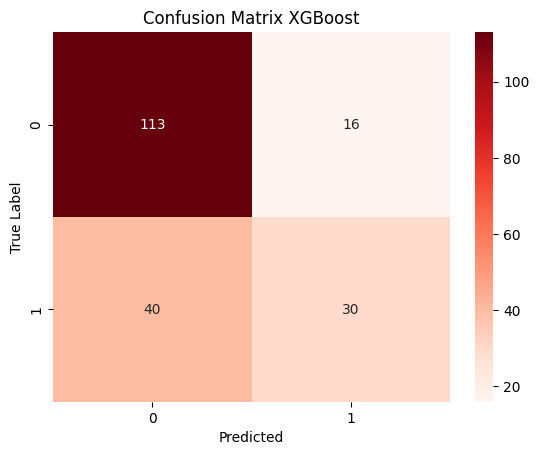

In [ ]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [ ]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'XGBoost',
 'Precision': 0.6521739130434783,
 'Recall': 0.42857142857142855,
 'F1 Score': 0.5172413793103449,
 'Accuracy': 0.7185929648241206,
 'ROC-AUC': np.float64(0.6867109634551495)}

**CatBoost**

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
#Обучение и прогноз модели CatBoost

name = 'CatBoost'
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0])

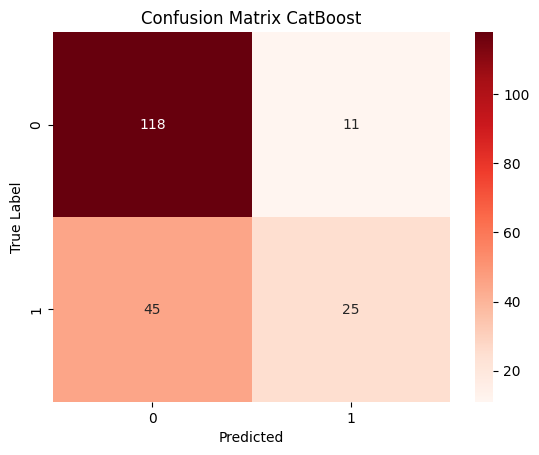

In [ ]:
#Построение и визуализация confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix ' + name)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [ ]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'CatBoost',
 'Precision': 0.6944444444444444,
 'Recall': 0.35714285714285715,
 'F1 Score': 0.4716981132075472,
 'Accuracy': 0.7185929648241206,
 'ROC-AUC': np.float64(0.7280177187153931)}

In [ ]:
results_df = pd.DataFrame(results)

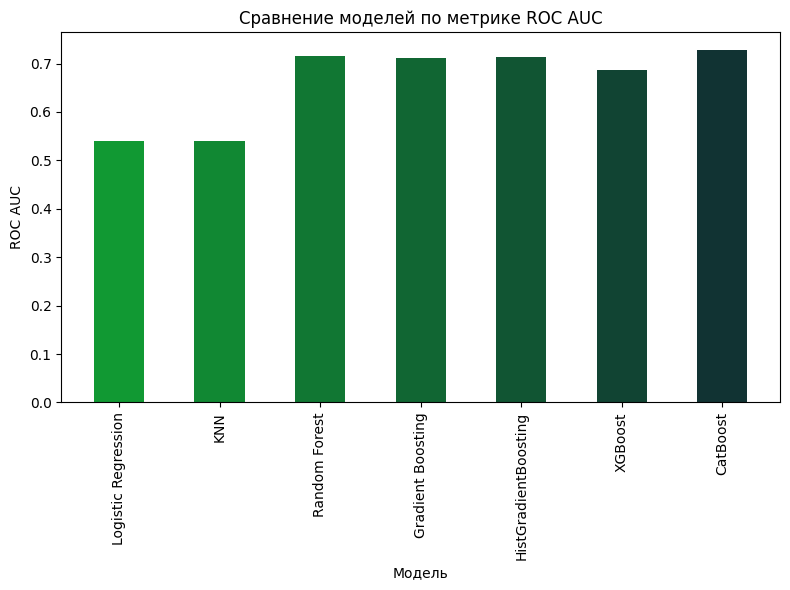

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Сравнение моделей по метрике ROC AUC')
colors =  [ '#193', '#183', '#173', '#163', '#153', '#143', '#133']
plt.xticks(rotation=90)
plt.bar(results_df['Model'], results_df['ROC-AUC'], width=0.5, color=colors)
plt.ylabel('ROC AUC')
plt.xlabel('Модель')
plt.tight_layout()
plt.show()

In [ ]:
print("Результаты классификации:")
results_df

Результаты классификации:


,Model,Precision,Recall,F1 Score,Accuracy,ROC-AUC
0,Logistic Regression,0.000000,0.000000,0.000000,0.648241,0.540310
1,KNN,0.519231,0.385714,0.442623,0.658291,0.539313
2,Random Forest,0.675676,0.357143,0.467290,0.713568,0.716334
3,Gradient Boosting,0.577778,0.371429,0.452174,0.683417,0.711406
4,HistGradientBoosting,0.586957,0.385714,0.465517,0.688442,0.713400
5,XGBoost,0.652174,0.428571,0.517241,0.718593,0.686711
6,CatBoost,0.694444,0.357143,0.471698,0.718593,0.728018


In [ ]:
print(f"Наилучший результат \n{results_df[results_df['ROC-AUC']==results_df['ROC-AUC'].max()]}")

Наилучший результат 
      Model  Precision    Recall  F1 Score  Accuracy   ROC-AUC
6  CatBoost   0.694444  0.357143  0.471698  0.718593  0.728018
